# A synthetic DC/IP model
## The synthetic model
Tina yesterday suggested a synthetic model that is kind of a mix inspired by both the Mjölkalunga (sediments) and Odarslöv (Dike). We have three main layers:
* 2 metres of dry sand
* 8 metres of saturated sand (aquifer)
* clay basement
plus two anomalies:
* a (silty?) block in the sand
* a near-vertical dyke

Assume a Terrameter LS2 measurement with 81 electrodes using the multiple-gradient array.

![Model](model.png)

In [1]:
# We first import the needed modules
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt  # submodule of pg
from pygimli.physics import ert  # subsubmodule

### The data scheme
We start with the data, creating a multi-gradient data with 81 electrodes, compute the geometric factors and display it. Note that the vertical axis does not refer to a pseudodepth but is a logical arrangement of data points so that every data is represented by a block of equal size, here of a Schlumberger (sl) type data. The data consist of four blocks with potential electrode distances of 1, 3, 5 and 7. One oblique line represents data with the same AB bipole.

Data: Sensors: 81 data: 1260, nonzero entries: ['a', 'b', 'm', 'n', 'valid']
Data: Sensors: 81 data: 1260, nonzero entries: ['a', 'b', 'k', 'm', 'n', 'valid']


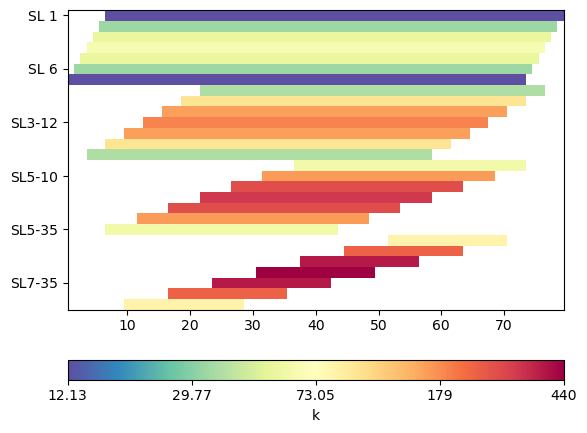

In [13]:
scheme = ert.createData(elecs=81, schemeName="gr")
scheme["k"] = ert.geometricFactors(scheme)
ert.show(scheme, "k")
print(scheme)

## The model geometry
As next step, we build up the synthetic model starting with the function `createWorld` to create a box, into which layers are inserted. Next, we will create arectangular anomaly, and finally a dike, which will explain us the region markers a little bit.

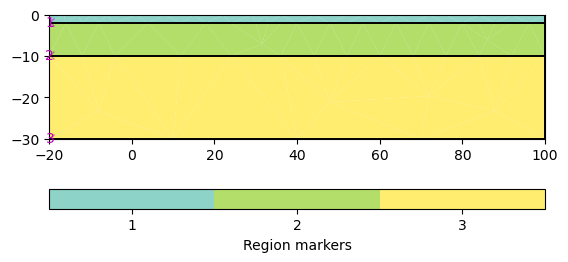

In [3]:
# We create a world with three layers
world = mt.createWorld(start=[-20, -30], end=[100, 0], layers=[-2, -10])
ax, cb = pg.show(world)

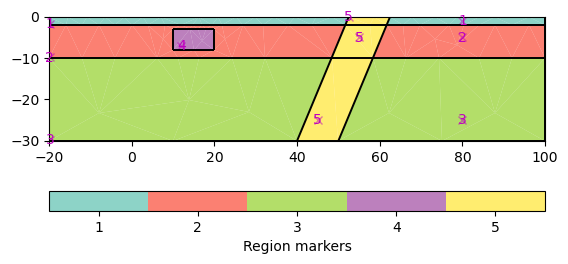

In [21]:
ano = mt.createRectangle(start=[10, -8], end=[20, -3], marker=4)
points = [[52.5, 0], [62.5, 0], [50, -30], [40, -30]]
dike = mt.createPolygon(points, isClosed=True, marker=5)
geo = world + ano + dike
geo.addRegionMarker([80, -1], marker=1)
geo.addRegionMarker([80, -5], marker=2)
geo.addRegionMarker([80, -25], marker=3)
geo.addRegionMarker([55, -5], marker=5)
geo.addRegionMarker([45, -25], marker=5)
ax, _ = pg.show(geo)
mt.exportPLC(geo, "geo.poly")

We add the electrode as nodes to the geometry to ensure sufficient accuracy, and create a mesh of the model. Then we populate the model with resistivities by using a map.

In [5]:
print(geo)
for sensor in scheme.sensors():
    geo.createNodeWithCheck(sensor)
print(geo)

Mesh: Nodes: 16 Cells: 0 Boundaries: 20
Mesh: Nodes: 97 Cells: 0 Boundaries: 20


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1e4ad4b9f70>)

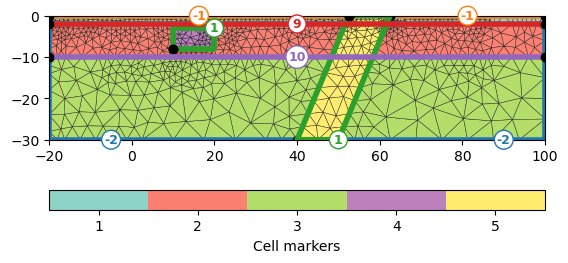

In [6]:
mesh = mt.createMesh(geo, quality=34)
pg.show(mesh, markers=True, showMesh=True)

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1e4c065deb0>)

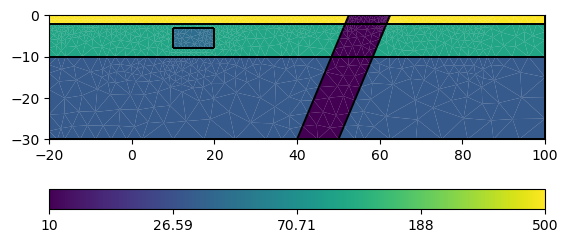

In [19]:
resmap = [[1, 500], # dry sand
          [2, 100], # saturated sand
          [3, 30],  # clay
          [4, 40],  # silt
          [5, 10]]  # dike
pg.show(mesh, resmap, logScale=True)
# One could also do it with a vector indexed by the cell markers
# resvec = np.array([0, 500, 100, 30, 40, 10])
# pg.show(mesh, resvec[mesh.cellMarkers()], logScale=True)

## The forward modelling
We simply call the `simulate` function of the ERT module, passing the mesh, the data scheme, and the resistivity map. Additionally we provide a noise level for estimating an error and generating Gaussian noise that is added to the data.

Data error estimate (min:max)  0.030002361258508265 : 0.03889033681180257


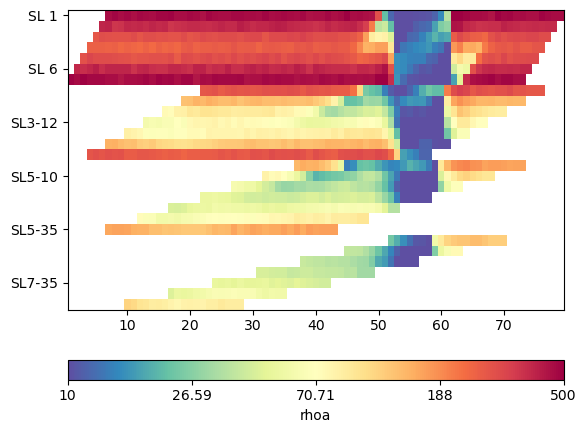

In [9]:
data = ert.simulate(mesh=mesh, scheme=scheme, res=resmap, noiseLevel=0.03)
ax, cb = ert.show(data, cMin=10, cMax=500)

In [20]:
# We save the mesh and the data for later use in other scripts
mesh.save("synth.bms")
data.save("synth.dat")

1

## DC Inversion
We use the ERT manager class passing the data. The inversion is only another simple one-liner to which we can pass any options for mesh, regularization or inversion.

In [10]:
mgr = ert.Manager(data)
mgr.invert(zWeight=0.2, verbose=True)

06/06/23 - 06:22:35 - pyGIMLi - INFO - Found 2 regions.
06/06/23 - 06:22:35 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
06/06/23 - 06:22:35 - pyGIMLi - INFO - Found 2 regions.
06/06/23 - 06:22:35 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
06/06/23 - 06:22:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
06/06/23 - 06:22:35 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
06/06/23 - 06:22:35 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 3369 Cells: 6328 Boundaries: 4950
06/06/23 - 06:22:35 - pyGIMLi - INFO - Use median(data values)=125.63953162583263
06/06/23 - 06:22:35 - pyGIMLi - INFO - Created startmodel from forward operator: 1318 [125.63953162583263,...,125.63953162583263]
06/06/23 - 06:22:35 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001E4ACA2C5E0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001E4ACA2C540>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001E4AC89B760>
min/max (data): 4.22/529
min/max (error): 3%/3.89%
min/max (start model): 126/126
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 76.78 (dPhi = 95.06%) lam: 20
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 37.02 (dPhi = 51.89%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 15.06 (dPhi = 58.63%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 5.82 (dPhi = 59.71%) lam: 20.0
--------------------------------------

1318 [455.68394298696836,...,22.826780219877584]

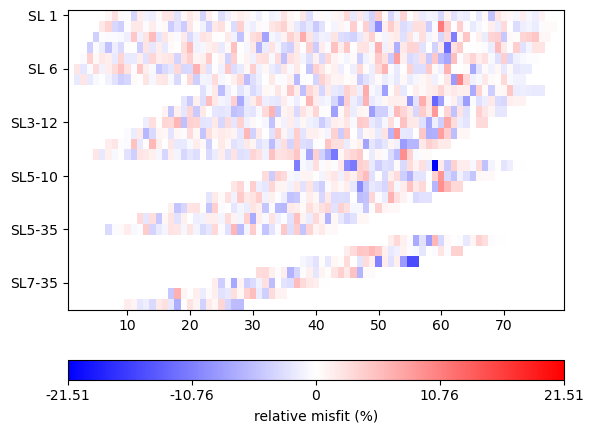

In [11]:
mgr.showMisfit()

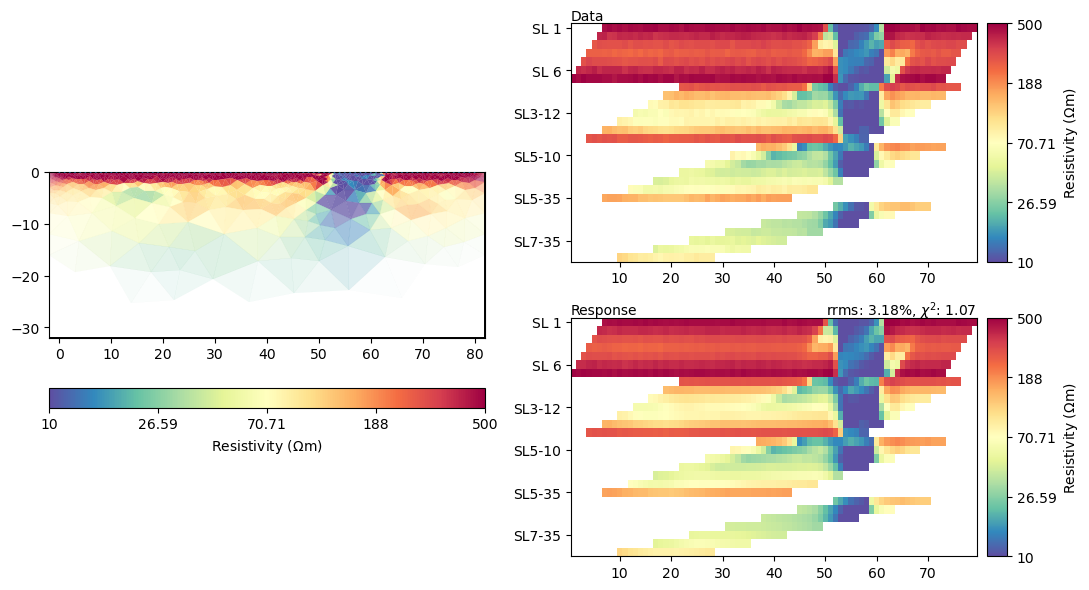

In [12]:
fig = mgr.showResultAndFit(cMin=10, cMax=500)